<a href="https://colab.research.google.com/github/shadfdz/CCTV/blob/main/CAE_anomaly_17JUN2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install and Import Libraries

In [ ]:
!pip install piqa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
torch.manual_seed(0)

from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision import transforms
from torch.nn import init
from torchsummary import summary
import seaborn as sn
from scipy.stats import iqr
import pandas as pd
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_fscore_support

from sklearn.model_selection import train_test_split

from google.colab import drive
from google.colab.patches import cv2_imshow
drive.mount('/content/drive',force_remount=True)
from piqa import SSIM

import cv2
import glob
import random
from random import sample
random.seed(0)

%matplotlib inline


Mounted at /content/drive


### Show Sample Image

In [ ]:
path = 'drive/MyDrive/cae_processed_dataset/'
f_name = '1_DE_165_552.wmv_256_4.jpg'

# path2 = 'drive/MyDrive/cae_anomalous/root35.jpg'

img = cv2.imread(path)
dim = img.shape
cv2_imshow(img)
print(dim[0], dim[1])

# Create Dataset Class and Data Loader

## Create Dataset Class

In [ ]:
class imagedataset(Dataset):
  def __init__(self, file_paths):
    self.file_paths = file_paths
    self.data = file_paths

  def __len__(self):
    return len(self.data)

  def __getitem__(self,index):
    img_path = self.data[index]
    img = cv2.imread(img_path)
    # crop
    img = img[:,80:560]
    # block out annotation
    img[25:100,350:480,] = 0
    img[50:75,:240,] = 0
    img[400:425,:35,] = 0
    img[400:425,190:300,] = 0
    img[400:425,455:480,] = 0
    img[280:305,:120] = 0
    dim = (256, 256)
    # resize and convert to tensor
    img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    img_tensor = torch.from_numpy(img) / 255.0
    img_tensor = img_tensor.permute(2, 0, 1)

    return img_tensor

In [ ]:
!ls drive/MyDrive/cae_processed_dataset5/* | wc -l

7430


## Create Dataloaders

In [ ]:
# # create dataset
from torch.utils.data import random_split

file_list = glob.glob('drive/MyDrive/cae_processed_dataset5/*')

dataset = imagedataset(file_list)
num_items = len(dataset)
num_train = round(num_items * 0.8)
num_val = num_items - num_train
train_ds, val_ds = random_split(dataset, [num_train, num_val])

train_dl = torch.utils.data.DataLoader(train_ds, batch_size=32, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=32, shuffle=False)

train_dl.pin_memory=True

In [ ]:
# check dataset
images = next(iter(train_dl))
print('original images shape:', images.shape)

original images shape: torch.Size([32, 3, 256, 256])


# Build Autoencoders

## AE No Max pool mirror (best one!)



In [ ]:
# type 2
class Encoder_CAE_Linear(nn.Module):
    def __init__(self):
        super(Encoder_CAE_Linear, self).__init__()
        conv_layers = []

        # conv1
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=8,kernel_size=3, stride=2)
        self.conv1.bias.data.zero_()
        self.bn1 = nn.BatchNorm2d(8)
        self.relu1 = nn.ReLU()

        # conv2
        self.conv2 = nn.Conv2d(in_channels=8,out_channels=16,kernel_size=3, stride=2)
        self.conv2.bias.data.zero_()
        self.bn2 = nn.BatchNorm2d(16)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.5)

        conv_layers += [self.conv1, self.bn1, self.relu1, self.conv2, self.bn2, self.relu2, self.dropout2]
  
        # conv 3
        self.conv3 = nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3, stride=2)
        self.conv3.bias.data.zero_()
        self.bn3 = nn.BatchNorm2d(32)
        self.relu3 = nn.ReLU()

        # conv 4
        self.conv4 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3, stride=2)
        self.conv4.bias.data.zero_()
        self.bn4 = nn.BatchNorm2d(64)
        self.relu4 = nn.ReLU()
        self.dropout4 = nn.Dropout(0.5)

        conv_layers += [self.conv3, self.bn3, self.relu3, self.conv4, self.bn4, self.relu4, self.dropout4]

        # layer 5 
        self.conv5 = nn.Conv2d(in_channels=64,out_channels=128, kernel_size=3, stride=2)
        self.conv5.bias.data.zero_()
        self.bn5 = nn.BatchNorm2d(128)
        self.relu5 = nn.ReLU()

        # layer 6
        self.conv6 = nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3, stride=2)
        self.conv6.bias.data.zero_()
        self.bn6 = nn.BatchNorm2d(256)
        self.relu6 = nn.ReLU()
        self.dropout6 = nn.Dropout(0.5)
        conv_layers += [self.conv5, self.bn5, self.relu5, self.conv6, self.bn6, self.relu6, self.dropout6]

        # Flatten and Linear section
        self.flatten = nn.Flatten(start_dim=1)
        self.fc1 = nn.Linear(2304,200)
        self.relu_fc1 = nn.ReLU()
        self.dropout_fc1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(200,50)
        self.relu_fc2 = nn.ReLU()

        # Convolutional Blocks
        self.conv = nn.Sequential(*conv_layers)

    def forward(self, x):

        # run convolutional blocks
        x = self.conv(x)
        s = self.relu_fc1(self.flatten(x))
        x = self.dropout_fc1(self.relu_fc1(self.fc1(self.flatten(x))))
        x = self.relu_fc2(self.fc2(x))
        
        return x


class Decoder_CAE_Linear(nn.Module):
    def __init__(self):
        super(Decoder_CAE_Linear, self).__init__()

        conv_layer = []

        # linear
        self.fc1 = nn.Linear(50, 200)
        self.relu_fc1 = nn.ReLU()
        self.dropout_fc1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(200, 2304)
        self.relu_fc2 = nn.ReLU()
        self.unflatten = nn.Unflatten(dim=1, 
        unflattened_size=(256, 3, 3))

        self.dropout_fc2 = nn.Dropout(0.5)

        # transpose layer 1
        self.convt1 = nn.ConvTranspose2d(in_channels=256, out_channels=128, stride=2,kernel_size=3)
        self.convt1.bias.data.zero_()
        self.bnt1 = nn.BatchNorm2d(128)
        self.relut1 = nn.ReLU()
   
        # transpose layer 2
        self.convt2 = nn.ConvTranspose2d(in_channels=128, out_channels=64, stride=2, kernel_size=3)
        self.convt2.bias.data.zero_()
        self.bnt2 = nn.BatchNorm2d(64)
        self.relut2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.5)

        # conv block 1
        conv_layer += [self.convt1, self.bnt1, self.relut1, self.convt2, self.bnt2, self.relut2, self.dropout2]

        # transpose layer 3
        self.convt3 = nn.ConvTranspose2d(in_channels=64, out_channels=32, stride=2, kernel_size=3)
        self.convt3.bias.data.zero_()
        self.bnt3 = nn.BatchNorm2d(32)
        self.relut3 = nn.ReLU()

        # transpose layer 4
        self.convt4 = nn.ConvTranspose2d(in_channels=32, out_channels=16, stride=2, kernel_size=3)
        self.convt4.bias.data.zero_()
        self.bnt4 = nn.BatchNorm2d(16)
        self.relut4 = nn.ReLU()
        self.dropout4 = nn.Dropout(0.5)

        # conv block 2
        conv_layer += [self.convt3, self.bnt3, self.relut3, self.convt4, self.bnt4, self.relut4, self.dropout4]

        # transpose layer 5
        self.convt5 = nn.ConvTranspose2d(in_channels=16, out_channels=8, stride=2, kernel_size=3, output_padding=1)
        self.convt5.bias.data.zero_()
        self.bnt5 = nn.BatchNorm2d(8)
        self.relut5 = nn.ReLU()
  
        # transpose layer 6
        self.convt6 = nn.ConvTranspose2d(in_channels=8, out_channels=3,kernel_size=2, stride=2)
        self.convt6.bias.data.zero_()
        self.bnt6 = nn.BatchNorm2d(3)
        self.sigmoid6 = nn.Sigmoid()

        conv_layer += [self.convt5, self.bnt5, self.relut5, self.convt6, self.bnt6, self.sigmoid6]
  
        # Convolutional Blocks
        self.conv = nn.Sequential(*conv_layer)

    def forward(self, x):

        # run convolutional blocks
        x = self.dropout_fc1(self.relu_fc1(self.fc1(x)))
        x = self.dropout_fc2(self.unflatten(self.relu_fc2(self.fc2(x))))
        x = self.conv(x)

        return x


## CNN -> LSTM?

# Modeling Training and Validation

## Create Train and Test Functions

In [ ]:
### Training function
def train_model(epoch, encoder, decoder, device, train_dl, loss_fn, optimizer, scheduler):

    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    running_loss = []
    for i, image_batch in enumerate(train_dl):
        # Move tensor to the proper device
        image_batch = image_batch.to(device, dtype=torch.float32)

        # Encode data
        encoded_data = encoder(image_batch)
        # Decode data
        decoded_data = decoder(encoded_data)
        # Evaluate loss
        # loss = 1.0 - ssim(decoded_data, image_batch).forward(x, y)
        loss = loss_fn(decoded_data, image_batch)
        loss.size()
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        # Print batch loss
        if i % 10 == 0:    # print every 10 mini-batches
           print('[%d, %5d] loss: %.4f' % (epoch + 1, i + 1, (loss.data)))
        running_loss.append(loss.detach().cpu().numpy())

    return np.mean(running_loss)
   

In [ ]:
### Testing function
def test_model(encoder, decoder, device, test_dl, loss_fn):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        running_loss = []
        for image_batch in test_dl:
            # Move tensor to the proper device
            image_batch = image_batch.to(device, dtype=torch.float32)
            # Encode data
            encoded_data = encoder(image_batch)
            # Decode data
            decoded_data = decoder(encoded_data)

            loss = loss_fn(decoded_data, image_batch)
            running_loss.append(loss.detach().cpu().numpy())

    return np.mean(running_loss)

## Training Parameters

In [ ]:
# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')


Selected device: cuda


In [ ]:
### Define functions
# for SSIM
class SSIMLoss(SSIM):
    def forward(self, x, y):
        return 1. - super().forward(x, y)

torch.use_deterministic_algorithms(False)
torch.manual_seed(0)

# create model 
encoder = Encoder_CAE_Linear()
decoder = Decoder_CAE_Linear()

# param optimization
optimize_params = [{'params': encoder.parameters()},
                   {'params': decoder.parameters()}]

# will hold train test loss
train_test_loss = {'train_loss':[],'val_loss':[]}

# learning rate
lr = 0.001

# create optimizer
optim = torch.optim.Adam(optimize_params, lr=lr, weight_decay=1e-05)

# loss function
criterion = nn.MSELoss()
# criterion = SSIMLoss().cuda()

# num epochs
num_epochs = 100

# train scheduler
scheduler = torch.optim.lr_scheduler.OneCycleLR(optim, max_lr=lr,
                                                steps_per_epoch=int(len(train_dl)+1),
                                                epochs=num_epochs,
                                                anneal_strategy='linear')

# Move both the encoder and the decoder to GPU
encoder.to(device)
decoder.to(device)

Decoder_CAE_Linear(
  (fc1): Linear(in_features=50, out_features=200, bias=True)
  (relu_fc1): ReLU()
  (dropout_fc1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=200, out_features=2304, bias=True)
  (relu_fc2): ReLU()
  (unflatten): Unflatten(dim=1, unflattened_size=(256, 3, 3))
  (dropout_fc2): Dropout(p=0.5, inplace=False)
  (convt1): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2))
  (bnt1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relut1): ReLU()
  (convt2): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2))
  (bnt2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relut2): ReLU()
  (dropout2): Dropout(p=0.5, inplace=False)
  (convt3): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2))
  (bnt3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relut3): ReLU()
  (convt4): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))

In [ ]:
summary(encoder, (3,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 127, 127]             448
            Conv2d-2         [-1, 16, 127, 127]             448
       BatchNorm2d-3         [-1, 16, 127, 127]              32
       BatchNorm2d-4         [-1, 16, 127, 127]              32
              ReLU-5         [-1, 16, 127, 127]               0
              ReLU-6         [-1, 16, 127, 127]               0
            Conv2d-7           [-1, 32, 63, 63]           4,640
            Conv2d-8           [-1, 32, 63, 63]           4,640
       BatchNorm2d-9           [-1, 32, 63, 63]              64
      BatchNorm2d-10           [-1, 32, 63, 63]              64
             ReLU-11           [-1, 32, 63, 63]               0
             ReLU-12           [-1, 32, 63, 63]               0
          Dropout-13           [-1, 32, 63, 63]               0
          Dropout-14           [-1, 32,

In [ ]:
# create model summary of encoder
summary(decoder, (50,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 200]          10,200
              ReLU-2                  [-1, 200]               0
           Dropout-3                  [-1, 200]               0
            Linear-4                 [-1, 2304]         463,104
              ReLU-5                 [-1, 2304]               0
         Unflatten-6            [-1, 256, 3, 3]               0
           Dropout-7            [-1, 256, 3, 3]               0
   ConvTranspose2d-8            [-1, 128, 7, 7]         295,040
   ConvTranspose2d-9            [-1, 128, 7, 7]         295,040
      BatchNorm2d-10            [-1, 128, 7, 7]             256
      BatchNorm2d-11            [-1, 128, 7, 7]             256
             ReLU-12            [-1, 128, 7, 7]               0
             ReLU-13            [-1, 128, 7, 7]               0
  ConvTranspose2d-14           [-1, 64,

## Train Model

EPOCH 1/100
[1,     1] loss: 0.1064
[1,    11] loss: 0.1028
[1,    21] loss: 0.0984
[1,    31] loss: 0.0947
[1,    41] loss: 0.0876
[1,    51] loss: 0.0867
[1,    61] loss: 0.0859
[1,    71] loss: 0.0834
[1,    81] loss: 0.0800
[1,    91] loss: 0.0795
[1,   101] loss: 0.0789
[1,   111] loss: 0.0791
[1,   121] loss: 0.0784
[1,   131] loss: 0.0751
[1,   141] loss: 0.0763
[1,   151] loss: 0.0758
[1,   161] loss: 0.0747
[1,   171] loss: 0.0759
[1,   181] loss: 0.0724
Train loss 0.08327 	 Val loss 0.06675
EPOCH 2/100
[2,     1] loss: 0.0726
[2,    11] loss: 0.0713
[2,    21] loss: 0.0738
[2,    31] loss: 0.0702
[2,    41] loss: 0.0730
[2,    51] loss: 0.0717
[2,    61] loss: 0.0731
[2,    71] loss: 0.0704
[2,    81] loss: 0.0718
[2,    91] loss: 0.0721
[2,   101] loss: 0.0709
[2,   111] loss: 0.0683
[2,   121] loss: 0.0700
[2,   131] loss: 0.0692
[2,   141] loss: 0.0686
[2,   151] loss: 0.0690
[2,   161] loss: 0.0669
[2,   171] loss: 0.0700
[2,   181] loss: 0.0687
Train loss 0.07023 	 Val l

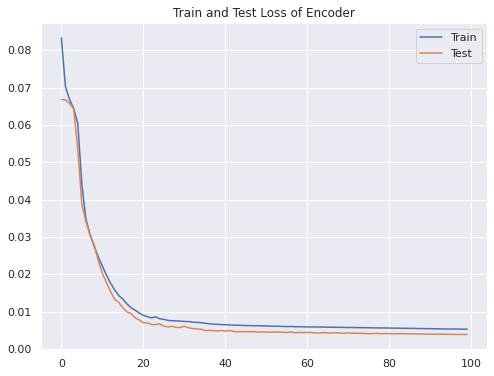

In [ ]:
# train loop
for epoch in range(num_epochs):
    print('EPOCH {}/{}'.format(epoch + 1, num_epochs))
    train_loss = train_model(epoch, encoder, decoder, device, train_dl, criterion, optim, scheduler)
    val_loss = test_model(encoder, decoder, device, val_dl, criterion)
    print('Train loss {:.5f} \t Val loss {:.5f}'.format(train_loss,val_loss))
    train_test_loss['train_loss'].append(train_loss)
    train_test_loss['val_loss'].append(val_loss)

# save model
encoder_path = 'drive/MyDrive/encoderAELin_05jul2021_100epoch_mirror_cae5.pt'
torch.save(encoder.state_dict(), encoder_path)
decoder_path = 'drive/MyDrive/decoderAELin_05jul2021_100epoch_mirror_cae5.pt'
torch.save(decoder.state_dict(), decoder_path)

sn.set()
fig = plt.figure(figsize=(8,6))
plt.title('Train and Test Loss of Encoder')
plt.plot(range(epoch+1),train_test_loss['train_loss'], label = 'Train')
plt.plot(range(epoch+1), train_test_loss['val_loss'], label = 'Test')
plt.legend()
plt.show()


# Test Model as Anomaly Classifier

## Load Models

In [ ]:
# load models
# load model
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
encoder1 = Encoder_CAE_Linear()
decoder1 = Decoder_CAE_Linear()
encoder1.load_state_dict(torch.load('drive/MyDrive/encoderAELin_05jul2021_100epoch_mirror_cae5.pt'))
decoder1.load_state_dict(torch.load('drive/MyDrive/decoderAELin_05jul2021_100epoch_mirror_cae5.pt'))
encoder1.to(device)
decoder1.to(device)


Decoder_CAE_Linear(
  (fc1): Linear(in_features=50, out_features=200, bias=True)
  (relu_fc1): ReLU()
  (dropout_fc1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=200, out_features=2304, bias=True)
  (relu_fc2): ReLU()
  (unflatten): Unflatten(dim=1, unflattened_size=(256, 3, 3))
  (dropout_fc2): Dropout(p=0.5, inplace=False)
  (convt1): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2))
  (bnt1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relut1): ReLU()
  (convt2): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2))
  (bnt2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relut2): ReLU()
  (dropout2): Dropout(p=0.5, inplace=False)
  (convt3): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2))
  (bnt3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relut3): ReLU()
  (convt4): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))

In [ ]:
# get list of models
ae_models = [(encoder1,decoder1)]

## Get Test Scores


In [ ]:
criterion = nn.MSELoss()
for ae in ae_models:
    val_loss = test_model(ae[0], ae[1], device, val_dl, criterion)
    print(val_loss)

0.0038849302


## Find Reconstruction Error in Images

In [ ]:
criterion = nn.MSELoss()

@torch.no_grad()
def get_reconstruction_error(encoder, decoder, device, img, show=False, to_gpu=False):
    """
    Function retrieves reconstruction error of image
    """
    encoder.eval()
    decoder.eval()

    if str(type(img)) == '<class \'torch.Tensor\'>':
        img_tensor = img.to(device, dtype=torch.float32)
        img_tensor = img_tensor[None,:,:,:]
        x = decoder(encoder(img_tensor))
        img_reco = x[0].permute(1, 2, 0).cpu().detach().numpy() * 255.0
        rerror = criterion(img_tensor,x)
        rerror = rerror.cpu().detach().item()
        return rerror

    # block out annotation
    img = img[:,80:560]
    img[25:100,350:480,] = 0
    img[50:75,:240,] = 0
    img[400:425,:35,] = 0
    img[400:425,190:300,] = 0
    img[400:425,455:480,] = 0
    img[280:305,:120] = 0
    dim = (256, 256)
    img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    img_tensor = torch.from_numpy(img) / 255.0
    img_tensor = img_tensor.permute(2, 0, 1).to(device, dtype=torch.float32)
    img_tensor = img_tensor[None,:,:,:]
    x = decoder(encoder(img_tensor))
    img_reco = x[0].permute(1, 2, 0).cpu().detach().numpy() * 255.0
    rerror = criterion(img_tensor,x)
    rerror = rerror.cpu().detach().item()
    if show:
        cv2_imshow(img)
        cv2_imshow(img_reco)
    # cv2.imwrite('abnormal_cae.jpg',img) to save photos
    # cv2.imwrite('abnormal_cae_re.jpg',img_reco)
  
    return rerror

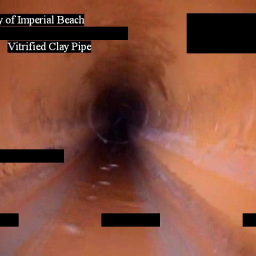

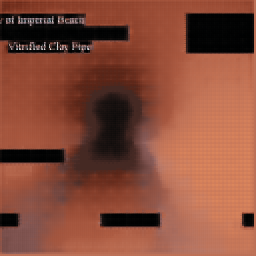

0.004289248026907444

In [ ]:
img = cv2.imread('drive/MyDrive/cae_processed_dataset_20JUN2022/1_DE_165_552.wmv_243_2.jpg')
r_error = get_reconstruction_error(encoder1, decoder1, device, img, True)
r_error


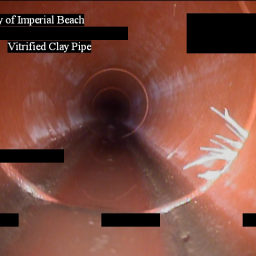

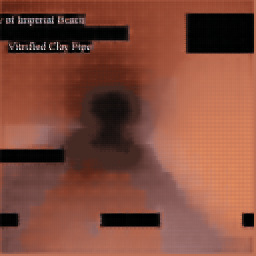

0.007179987616837025


In [ ]:
img = cv2.imread('drive/MyDrive/cae_anomalous/root36.jpg')
r_error = get_reconstruction_error(encoder1, decoder1, device, img,True)
print(r_error)

In [ ]:
val_img_score_list = []
for img in val_ds:
  val_img_score_list.append(get_reconstruction_error(ae_models[0][0], ae_models[0][1], device, img))

In [ ]:
anomalous_img = glob.glob('drive/MyDrive/cae_roots_frames/*.jpg')
anomaly_img_score_roots_list = []
for img in anomalous_img:
  img_array = cv2.imread(img)
  anomaly_img_score_roots_list.append(get_reconstruction_error(ae_models[0][0], ae_models[0][1], device, img_array))

In [ ]:
anomalous_img

df_anomaly = pd.DataFrame(data={"file":anomalous_img,
                                "score":anomaly_img_score_roots_list[0]})

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


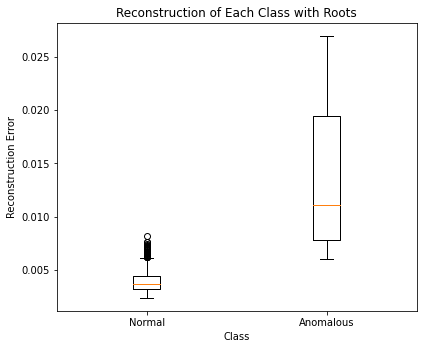

In [ ]:
data = [val_img_score_list, anomaly_img_score_roots_list]
fig = plt.figure(figsize =(5, 4))
 
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
bp = ax.boxplot(data)

plt.xlabel("Class")
plt.ylabel("Reconstruction Error")
plt.xticks([1, 2], ['Normal', 'Anomalous'])
plt.title("Reconstruction of Each Class with Roots")
# plt.savefig('drive/MyDrive/lin30epoch.png')
plt.show()

In [ ]:
anomalous_img = glob.glob('drive/MyDrive/cae_test_21JUN2022/*.jpg')
anomaly_img_score_roots_grease_list = []
for img in anomalous_img:
  img_array = cv2.imread(img)
  anomaly_img_score_roots_grease_list.append(get_reconstruction_error(ae_models[0][0], ae_models[0][1], device, img_array))

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


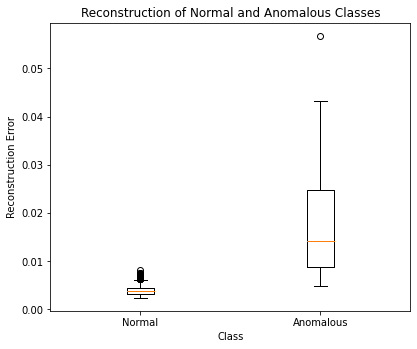

In [ ]:
data = [val_img_score_list, anomaly_img_score_roots_grease_list]

fig = plt.figure(figsize =(5, 4))
 
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
bp = ax.boxplot(data)

plt.xlabel("Class")
plt.ylabel("Reconstruction Error")
plt.xticks([1, 2], ['Normal', 'Anomalous'])
plt.title("Reconstruction of Normal and Anomalous Classes")
plt.savefig('drive/MyDrive/re_roots_grease.png')
plt.show()

## ROC Curve

In [ ]:
# with roots
# labels = [0 for i in range(len(val_img_score_list))] + [1 for i in range(len(anomaly_img_score_roots_list))]
# d = {'ground_truth': labels, 
#      'reconstruction_error': val_img_score_list + anomaly_img_score_roots_list}

# with roots and grease
labels = [0 for i in range(len(val_img_score_list))] + [1 for i in range(len(anomaly_img_score_roots_grease_list))]
d = {'ground_truth': labels, 
     'reconstruction_error': val_img_score_list + anomaly_img_score_roots_grease_list}

df = pd.DataFrame(d)

In [ ]:
df.ground_truth.value_counts()

0    1486
1      95
Name: ground_truth, dtype: int64

In [ ]:
from sklearn import metrics
# convert dictionary to dataframe

epoch_names = df.columns.to_list()
epoch_names.remove('ground_truth')

fpr, tpr, thres = roc_curve(df.ground_truth, df.reconstruction_error, pos_label=1)

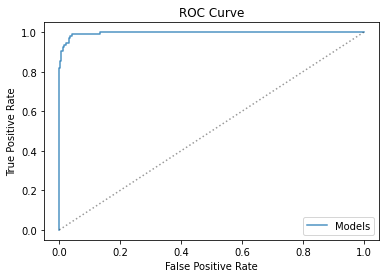

In [ ]:
ns = [i/len(tpr) for i in range(len(tpr)+1)]
plt.plot(fpr, tpr,alpha=0.8)
plt.plot(ns,ns,color='black', alpha=0.4, linestyle='dotted')
plt.legend(['Models'])
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.savefig('drive/MyDrive/ROC_09MAY2022.png')
plt.show()

## AUC

In [ ]:
auc(fpr, tpr)

0.9961039880994546

## Find G-Means
Geometric mean of sensitivity and specificity sqrt(TPR * (1-FPR))

In [ ]:
gmean = np.sqrt(np.array(tpr) * (1 - np.array(fpr)))
# Find the optimal threshold
index = np.argmax(gmean)

thresholdOpt = round(thres[index], ndigits = 5)
thresholdOpt

0.00565

## Precision, Recall, F1 at Gmean

In [ ]:
# Using Gmean as threshold
df["Gmean"] = [1 if i > thresholdOpt else 0 for i in df["reconstruction_error"]]
precision_recall_fscore_support(df.ground_truth, df.Gmean)

(array([0.99929923, 0.61038961]),
 array([0.95962315, 0.98947368]),
 array([0.97905939, 0.75502008]),
 array([1486,   95]))

## Precision, Recall, F1 at Varying Quantiles



In [ ]:
# find 75 quantile and assign to df
q75_threshold = df.loc[(df["ground_truth"]==0),"reconstruction_error"].quantile(0.75)
q75_threshold
df["q75"] = [1 if i > q75_threshold else 0 for i in df["reconstruction_error"]]

precision_recall_fscore_support(df.ground_truth, df.q75)

(array([1.        , 0.20342612]),
 array([0.74966353, 1.        ]),
 array([0.85692308, 0.33807829]),
 array([1486,   95]))

In [ ]:
# find 99 quantile and assign to df
q99_threshold = df.loc[(df["ground_truth"]==0),"reconstruction_error"].quantile(0.99)

df["q99"] = [1 if i > q99_threshold else 0 for i in df["reconstruction_error"]]
precision_recall_fscore_support(df.ground_truth, df.q99)


(array([0.99391892, 0.85148515]),
 array([0.98990579, 0.90526316]),
 array([0.99190829, 0.87755102]),
 array([1486,   95]))

In [ ]:
import plotly.express as px
from sklearn.metrics import confusion_matrix
confusion_matrix(df.ground_truth, df.Gmean)

z = confusion_matrix(df.ground_truth, df.Gmean)
names = ['0','1']
fig = px.imshow(z, text_auto=True, x = names, y = names)
fig.update_layout(
    title = 'Confusion Matrix'
)

fig.show()

array([[1471,   15],
       [   9,   86]])

## Looking At Distribution for Data Noise

In [ ]:
# !ls drive/MyDrive/cae_processed_dataset2/ | wc -l
file_list = glob.glob('drive/MyDrive/cae_processed_dataset_20JUN2022/*')
anomaly_list = []

for f_name in file_list:
  img = cv2.imread(f_name)
  anomaly_list.append(get_reconstruction_error(ae_models[0][0], ae_models[0][1], device, img))

df_anomaly = pd.DataFrame({
    'file_name' : file_list,
    'anomaly_score' : anomaly_list
})

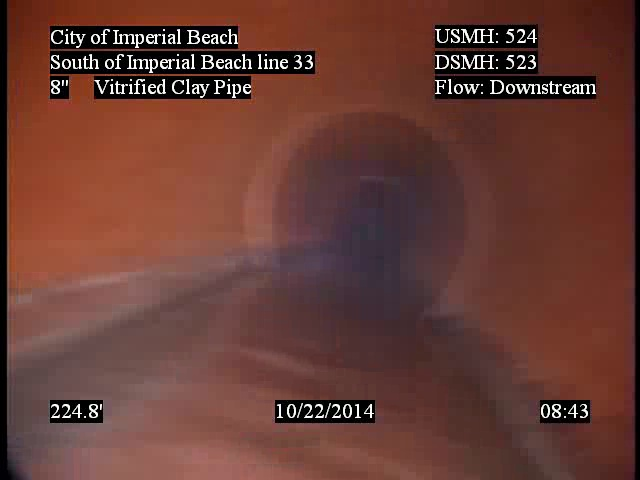

In [ ]:
file_name = df_anomaly.iloc[df_anomaly.anomaly_score.idxmax(),:][0]
img = cv2.imread(file_name)
cv2_imshow(img)

In [ ]:
# sort the anomalous data
df_anomaly_sorted = df_anomaly.sort_values("anomaly_score", ignore_index=True)

In [ ]:
# add vid name colum
df_anomaly_sorted["vid_name"] = df_anomaly_sorted['file_name'].map(lambda x: x.split('/')[3].split('.')[0])
# add time in sec
df_anomaly_sorted['sec'] = df_anomaly_sorted['file_name'].map(lambda x: x.split('/')[3].split('.')[1].split('_')[1])

In [ ]:
df_anomaly_sorted.tail(50)

,file_name,anomaly_score,vid_name,sec
9490,drive/MyDrive/cae_processed_dataset_20JUN2022/...,0.010998,1_342_341,250
9491,drive/MyDrive/cae_processed_dataset_20JUN2022/...,0.011008,1_341_302,400
9492,drive/MyDrive/cae_processed_dataset_20JUN2022/...,0.011026,1_342_341,257
9493,drive/MyDrive/cae_processed_dataset_20JUN2022/...,0.011036,1_342_341,248
9494,drive/MyDrive/cae_processed_dataset_20JUN2022/...,0.011048,1_341_302,401
9495,drive/MyDrive/cae_processed_dataset_20JUN2022/...,0.011068,1_342_341,254
9496,drive/MyDrive/cae_processed_dataset_20JUN2022/...,0.011119,1_341_302,402
9497,drive/MyDrive/cae_processed_dataset_20JUN2022/...,0.011279,1_341_302,402
9498,drive/MyDrive/cae_processed_dataset_20JUN2022/...,0.011291,1_341_302,403
9499,drive/MyDrive/cae_processed_dataset_20JUN2022/...,0.011399,1_341_302,401


In [ ]:
# look at data
df_anomaly_sorted.loc[(df_anomaly_sorted['vid_name']=='1_336_337')].iloc[-95,0:2]
# ['sec'].value_counts()

file_name        drive/MyDrive/cae_processed_dataset2/1_336_337...
anomaly_score                                             0.007359
Name: 9521, dtype: object

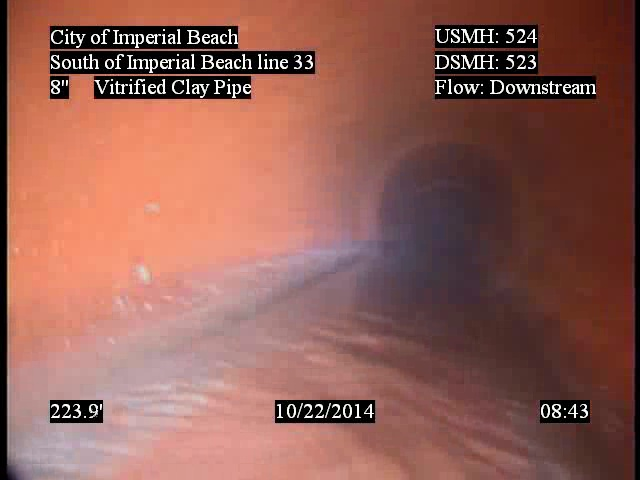

In [ ]:
img = cv2.imread(df_anomaly_sorted.iloc[-3,0])
df_anomaly_sorted.iloc[-40,0]
cv2_imshow(img)
# df_anomaly_sorted.iloc[-2,:]
# print()
# cv2_imshow(img)

In [ ]:
df_anomaly_sorted.loc[(df_anomaly_sorted["anomaly_score"]>0.0081)]["vid_name"].value_counts()


1_342_341       189
1_341_302       131
1_354_364        78
1_524_523        47
1_336_337        40
1_523_425        39
1_355_342        24
1_DE_165_552     12
1_DE_107_346      9
1_348_360         8
1_341_302_1       2
1_528_526         2
Name: vid_name, dtype: int64

In [ ]:
anomaly_img_score_roots_list

In [ ]:
df_anomaly_sorted.loc[(df_anomaly_sorted["anomaly_score"]>0.0081) & (df_anomaly_sorted["vid_name"]=="1_341_302")]["sec"].sort_values().unique()

array(['378', '379', '384', '385', '386', '387', '388', '389', '390',
       '391', '393', '395', '397', '398', '400', '401', '402', '403',
       '404', '405', '423', '520', '523'], dtype=object)

In [ ]:
df_anomaly_sorted.loc[(df_anomaly_sorted["anomaly_score"]>0.0081) & (df_anomaly_sorted["vid_name"]=="1_354_364"),["anomaly_score","sec"]].groupby("sec").mean().sort_values("sec")

,anomaly_score
sec,
540,0.008873
546,0.009214
547,0.008932
550,0.008544
557,0.009210
558,0.009423
560,0.008535
561,0.008566
564,0.008481


## Reconstruction Error in Videos

In [ ]:
# upload video section by frame
!ls drive/MyDrive

In [ ]:
def get_re_video(start, end, vid_cap, output_folder, f_name, encoder, decoder, device):
  """
  function retreives video caputre instance and saves video frames per second in a 
  subdirectory named after video file. file saved as jpg with video file name + sec
  data frame returned with file names of frames 
  :param vid_cap: instance of cv2 video capture
  :param output_folder: str of output folder name
  :param directory: str directory path
  :param f_name: str cctv filename
  :return: dataframe
  """
  # retrieve if frame exists
  frame_exists, frame = vid_cap.read()
  # to hold data for df
  frames_data_array = []

  # to hold df for reconstruction error every sec
  list_to_df = []
  # get vid properties
  length = int(vid_cap.get(cv2.CAP_PROP_FRAME_COUNT) / vid_cap.get(cv2.CAP_PROP_FPS))

  if end >= length:
    return 0
  img_array = []

  # loop through frames
  for i in range(end-start+1):
    vid_cap.set(cv2.CAP_PROP_POS_MSEC, ((start + i) * 1000))
    frame_exists, frame = vid_cap.read()

    r_error = get_reconstruction_error(encoder, decoder, device, frame)
    re_string = '{:5f}'.format(r_error)
    list_to_df.append([start+i, r_error])
    font = cv2.FONT_HERSHEY_SIMPLEX
    org = (300, 120)
    color = (0, 255, 0)
    thickness = 1
    fontScale = 0.75
    image = cv2.putText(frame, re_string, org, font, fontScale, color, thickness, cv2.LINE_AA)
    img_array.append(image)

  size = (480,640)
  out = cv2.VideoWriter(output_folder + f_name + '.avi', cv2.VideoWriter_fourcc(*"MJPG"), 2,(640,480))

  for i in range(len(img_array)):
    out.write(img_array[i])
  out.release()

  df = pd.DataFrame(list_to_df, columns=['seconds','reconstruction_error'])

  return df, img_array

In [ ]:
!ls drive/MyDrive

In [ ]:
# small root anomaly
f_path = 'drive/MyDrive/CCTV_2014_10_Downstream/1_355_342.wmv'
out_path = 'drive/MyDrive/cae_vid_test/'
vid_raw = cv2.VideoCapture(f_path)
re_df, img_arr = get_re_video(735, 815, vid_raw, out_path,'small_root_anomaly', encoder1, decoder1, device)

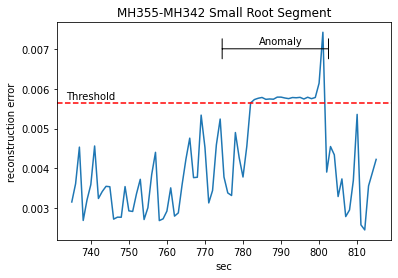

In [ ]:
plt.plot(re_df.seconds,re_df.reconstruction_error)
plt.axhline(y = thresholdOpt, color = 'r', linestyle = 'dashed', label = "red line")  
plt.annotate('', xy=(774, 0.007), xytext=(803, 0.007), xycoords='data', textcoords='data',
            arrowprops={'arrowstyle': '|-|'})
plt.annotate('Anomaly', xy=(790, 0.0072), ha='center', va='center')
plt.annotate('Threshold', xy=(740, 0.0058), ha='center', va='center')
plt.xlabel('sec')
plt.ylabel('reconstruction error')
plt.title('MH355-MH342 Small Root Segment')
plt.savefig('anomaly_seq_small.png')
plt.show()



In [ ]:
# large root anomaly
f_path = 'drive/MyDrive/CCTV_2014_10_Downstream/1_529_528.wmv'
out_path = 'drive/MyDrive/cae_vid_test/'
vid_raw = cv2.VideoCapture(f_path)
re_df2, img_arr = get_re_video(65, 200, vid_raw, out_path,'large_root_anomaly', encoder1, decoder1, device)

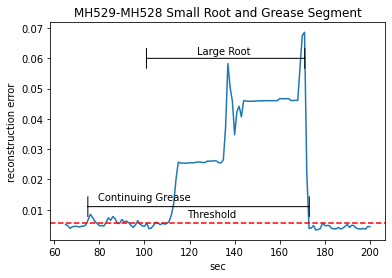

In [ ]:
plt.plot(re_df2.seconds,re_df2.reconstruction_error)
plt.xlabel('sec')
plt.ylabel('reconstruction error')


plt.axhline(y = thresholdOpt, color = 'r', linestyle = 'dashed', label = "red line") 

plt.annotate('', xy=(100, 0.06), xytext=(172, 0.06), xycoords='data', textcoords='data',
            arrowprops={'arrowstyle': '|-|'})
plt.annotate('Large Root', xy=(135, 0.0625), ha='center', va='center')

plt.annotate('', xy=(74, 0.011), xytext=(174, 0.011), xycoords='data', textcoords='data',
            arrowprops={'arrowstyle': '|-|'})
plt.annotate('Continuing Grease', xy=(100, 0.014), ha='center', va='center')

plt.annotate('Threshold', xy=(130, 0.0085), ha='center', va='center')

plt.title('MH529-MH528 Small Root and Grease Segment')
plt.savefig('anomaly_seq_large.png')
plt.show()
